In [1]:
%pylab inline
from __future__ import division  
from showmat import showmat 
from scipy.sparse import * 
from scipy.sparse.linalg import eigsh # calculates eigenvectors of hermitian matrices

Populating the interactive namespace from numpy and matplotlib


We want to make a finite difference approximation to the 2D Laplacian

$$\nabla^2 \psi(x,y)= \frac{1}{\delta^2}\left[\psi(x+\delta,y)+\psi(x-\delta,y)+\psi(x,y+\delta)+\psi(x,y-\delta)-4\psi(x,y)\right]$$

The most natural representation would be as a rank 4 tensor.  That is if we define

$$\phi=\nabla^2\psi$$

Then $\phi(x,y)$ is some linear combination of $\psi(x^\prime,y^\prime)$.  Unfortunately, most software packages do not deal well with rank 4 tensors.  [For example, you can not use off-the-shelf algorithms to get their Eigenvalues.]

One approach is to number the points on our 2D grid, and think of it as a 1D list.  For example, imagine we have a $3\times 3$ grid:

In [2]:
mesh=arange(9,dtype=integer).reshape(3,3)
mesh

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

These numbers will label the points so that

$$ \begin{array}{c}
\psi_0=\psi(x=0,y=0)\cr \psi_1=\psi(x=1,y=0)\cr \psi_2=\psi(x=2,y=0)\cr \psi_3=\psi(x=0,y=1)\cr
\psi_4=\psi(x=1,y=1)\cr
\psi_5=\psi(x=2,y=1)\cr
\psi_6=\psi(x=0,y=2)\cr
\psi_7=\psi(x=1,y=2)\cr
\psi_8=\psi(x=2,y=2)
\end{array}$$

We need a function which takes a vector $\psi_1,\psi_2,\cdots$ and rearanges them into the right geometric order

In [3]:
def twodrep(vec):
    """ twodrep reshapes a linear array into a square array"""
    size=int(sqrt(len(vec))) # How many psi's do we have
    ans=vec.copy()
    return ans.reshape(size,size) 

In [4]:
test=array((0,0,0,0,1,0,0,0,0)) 

In [5]:
testarray=twodrep(test)  
testarray                

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [6]:
showmat(testarray)  

,,
,1,
,,


We now generate the laplacian -- here I will take dx=1, but we can scale it later.  First lets just make an empty matrix

In [7]:
laplacematrix=zeros((9,9))
showmat(laplacematrix)

,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,


In [8]:
# set diagonal elements
laplacematrix[mesh,mesh]=-4
showmat(laplacematrix)

-4,,,,,,,,
,-4,,,,,,,
,,-4,,,,,,
,,,-4,,,,,
,,,,-4,,,,
,,,,,-4,,,
,,,,,,-4,,
,,,,,,,-4,
,,,,,,,,-4


Next let us set all of the shifted one-to-the right elements.  Since we can't hop to the right from the rightmost elements (unless we use periodic boundary conditions) we need to generate a matrix which has the last column of mesh removed

In [9]:
left=mesh[:,:-1]
left

array([[0, 1],
       [3, 4],
       [6, 7]])

We do the same thing with the right

In [10]:
right=mesh[:,1:]
right

array([[1, 2],
       [4, 5],
       [7, 8]])

setting the hopping right terms is then easy

In [11]:
laplacematrix[[left,right]]=1
showmat(laplacematrix)

-4,1,,,,,,,
,-4,1,,,,,,
,,-4,,,,,,
,,,-4,1,,,,
,,,,-4,1,,,
,,,,,-4,,,
,,,,,,-4,1,
,,,,,,,-4,1
,,,,,,,,-4


hopping left is just

In [12]:
laplacematrix[[right,left]]=1
showmat(laplacematrix)

-4,1,,,,,,,
1,-4,1,,,,,,
,1,-4,,,,,,
,,,-4,1,,,,
,,,1,-4,1,,,
,,,,1,-4,,,
,,,,,,-4,1,
,,,,,,1,-4,1
,,,,,,,1,-4


The 3x3 blocks which correspond to individual rows should be clear

Add the hopping up and down terms to laplacematrix

In [13]:
down=mesh[:-1,:]
up=mesh[1:,:]
laplacematrix[[up,down]]=1
laplacematrix[[down,up]]=1
showmat(laplacematrix)

-4,1,,1,,,,,
1,-4,1,,1,,,,
,1,-4,,,1,,,
1,,,-4,1,,1,,
,1,,1,-4,1,,1,
,,1,,1,-4,,,1
,,,1,,,-4,1,
,,,,1,,1,-4,1
,,,,,1,,1,-4


In [14]:
showmat(twodrep(laplacematrix.dot(test)))

,1,
1,-4,1
,1,


We can be more efficient if we use sparse arrays so that we don't store all of those zeros

We will use the "dictionary of keys" form of a sparse matrix.

In [15]:
sparselaplace=dok_matrix((9,9))
sparselaplace

<9x9 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Dictionary Of Keys format>

In [16]:
showmat(sparselaplace)

,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,


In [17]:
sparselaplace[mesh,mesh]=-4

In [18]:
sparselaplace[mesh,mesh]=-4
sparselaplace[left,right]=1
sparselaplace[right,left]=1
showmat(sparselaplace)

-4,1,,,,,,,
1,-4,1,,,,,,
,1,-4,,,,,,
,,,-4,1,,,,
,,,1,-4,1,,,
,,,,1,-4,,,
,,,,,,-4,1,
,,,,,,1,-4,1
,,,,,,,1,-4


Add the up and down hoppings

In [19]:
sparselaplace[up,down]=1
sparselaplace[down,up]=1
showmat(sparselaplace)

-4,1,,1,,,,,
1,-4,1,,1,,,,
,1,-4,,,1,,,
1,,,-4,1,,1,,
,1,,1,-4,1,,1,
,,1,,1,-4,,,1
,,,1,,,-4,1,
,,,,1,,1,-4,1
,,,,,1,,1,-4


Now lets encapsulate this into a function

In [20]:
def makelaplacematrix(numgridpoints,dx):
    """makelaplacematrix(numgridpoints,dx) returns a (numgridpoints^2)x(numgridpoints^2) square matrix
    which represents the laplacian on the 2d grid with grid spacing dx.  It is in the dok_matrix format,
    and has hard wall boundary conditions"""
    mesh=arange(numgridpoints**2,dtype=integer).reshape(numgridpoints,numgridpoints)
    left=mesh[:,:-1]
    right=mesh[:,1:]
    down=mesh[:-1,:]
    up=mesh[1:,:]
    sparselaplace=dok_matrix((numgridpoints**2,numgridpoints**2))
    sparselaplace[mesh,mesh]=-4
    sparselaplace[left,right]=1
    sparselaplace[right,left]=1
    sparselaplace[up,down]=1
    sparselaplace[down,up]=1
    return (1/dx**2)*sparselaplace

In [21]:
lmat=makelaplacematrix(10,0.1)
showmat(lmat)

-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,100,-400,,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,,,,,,,,,,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [22]:
test2=zeros(100)
test2[45]=1
showmat(twodrep(test2))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,1,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [23]:
test3=lmat.dot(test2)
showmat(twodrep(test3))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,100,,,,
,,,,100,-400,100,,,
,,,,,100,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [24]:
test4=zeros(100)
test4[40]=1
showmat(twodrep(test4))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
1,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [25]:
test5=lmat.dot(test4)
showmat(twodrep(test5))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
100,,,,,,,,,
-400,100,,,,,,,,
100,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


Here I show how to apply this technique to finding the eigenstates of a 2D hard wall box

In [26]:
boxham=csc_matrix(-0.5*makelaplacematrix(50,0.02))
energies,states=eigsh(boxham, k=10, sigma=0., return_eigenvectors=True)
energies

array([ 9.48335631, 23.69040398, 23.69040398, 37.89745164, 47.30892895,
       47.30892895, 61.51597661, 61.51597661, 80.24933807, 80.24933807])

We can compare this to what we expect the exact answer to be

In [27]:
vals=array([[pi**2*(n**2+m**2)/2 for n in arange(1,5)] for m in arange(1,5)]).flatten()
vals.sort()
vals

array([  9.8696044 ,  24.674011  ,  24.674011  ,  39.4784176 ,
        49.34802201,  49.34802201,  64.15242861,  64.15242861,
        83.89163741,  83.89163741,  88.82643961,  98.69604401,
        98.69604401, 123.37005501, 123.37005501, 157.91367042])

We can also plot some of the wavefunctions

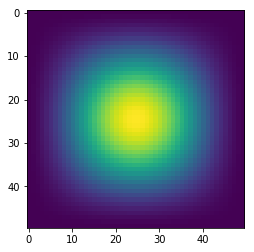

In [28]:
imshow(abs(twodrep(states[:,0]))**2)

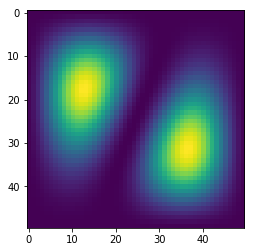

In [29]:
imshow(abs(twodrep(states[:,1]))**2)

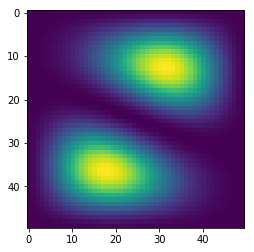

In [30]:
imshow(abs(twodrep(states[:,2]))**2)

These last two states are degenerate

In [31]:
print(energies[1],energies[2])

23.690403977550478 23.690403977550517


Thus linear combinations are also eigenstates:

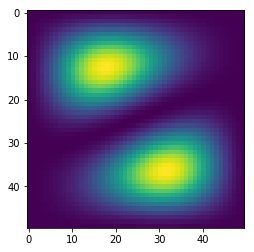

In [32]:
imshow(abs(twodrep(states[:,1]+states[:,2]))**2)

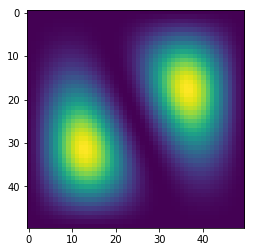

In [33]:
imshow(abs(twodrep(states[:,1]-states[:,2]))**2)

Here is a higher mode

In [34]:
en,st=eigsh(boxham, k=1, sigma=520., return_eigenvectors=True)

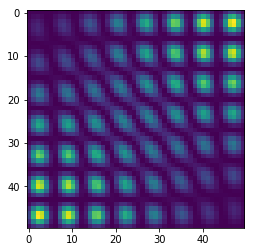

In [35]:
imshow(abs(twodrep(st[:,0]))**2)

Suppose we have a 2D potential on our grid.  For example, here is a 2D harmonic oscillator potential.

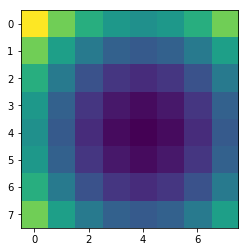

In [36]:
potvals=array([[(x**2+y**2)/2 for x in arange(-2,2,0.5)] 
               for y in arange(-2,2,0.5)])
imshow(potvals)

To make the potential matrix we first "unwrap" this grid into a linear list of numbers.  First we need to know how many pixels we have.

In [37]:
numpixels=product(potvals.shape)
numpixels

64

We unwrap them via

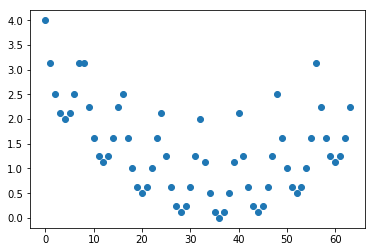

In [38]:
unwrapped=potvals.reshape(numpixels)
plot(unwrapped,"o")

Our potential matrix will be a 64x64 matrix that when applied to the 64 values of psi, multiplies each of them by $V$ at that site

In [39]:
potmat=dia_matrix((unwrapped,0),shape=[numpixels,numpixels])

In [40]:
showmat(potmat)

4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,2.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,2.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,2.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,2.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,2.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,1.62,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


We can encapsulate this via

In [41]:
def makepotmat(potvals):
    numpixels=product(potvals.shape)
    unwrapped=potvals.reshape(numpixels)
    return dia_matrix((unwrapped,0),shape=[numpixels,numpixels])